In [1]:
#Import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import glob
%matplotlib qt

True


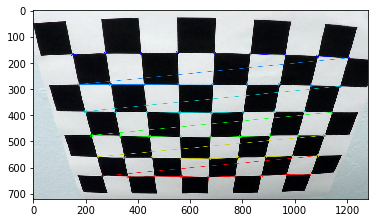

In [2]:
test_img = cv2.imread('camera_cal/calibration2.jpg') #read in each image
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY) #convert to grayscale
t_ret,t_corners = cv2.findChessboardCorners(test_gray,(9,6),None)
print(t_ret)
if t_ret==True:
    test_img = cv2.drawChessboardCorners(test_img,(9,6),t_corners,t_ret)
    %matplotlib inline
    plt.imshow(test_img)

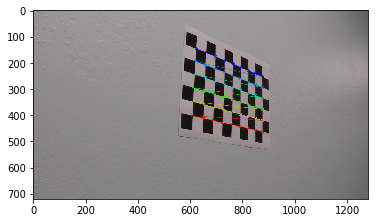

In [3]:
# Iterate through the images, get the camera calibration chessboard corners
images = glob.glob('camera_cal/calibration*.jpg')

# initialize arrays to store object point and image points
objpoints = []
imgpoints = []

objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    img = cv2.imread(fname) #read in each image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)

In [4]:
# calculate calibration parameters and define function

#gray = cv2.cvtColor(cv2.imread('camera_cal/calibration2.jpg'), cv2.COLOR_BGR2GRAY)
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

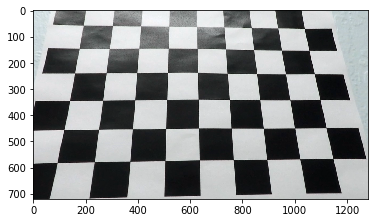

In [5]:
# test calibration and undistortion performance. Looks good?
undistorted = cal_undistort(cv2.imread('camera_cal/calibration3.jpg'), objpoints, imgpoints)
plt.imshow(undistorted)
mpimg.imsave("undistorted cali3.jpg",undistorted)

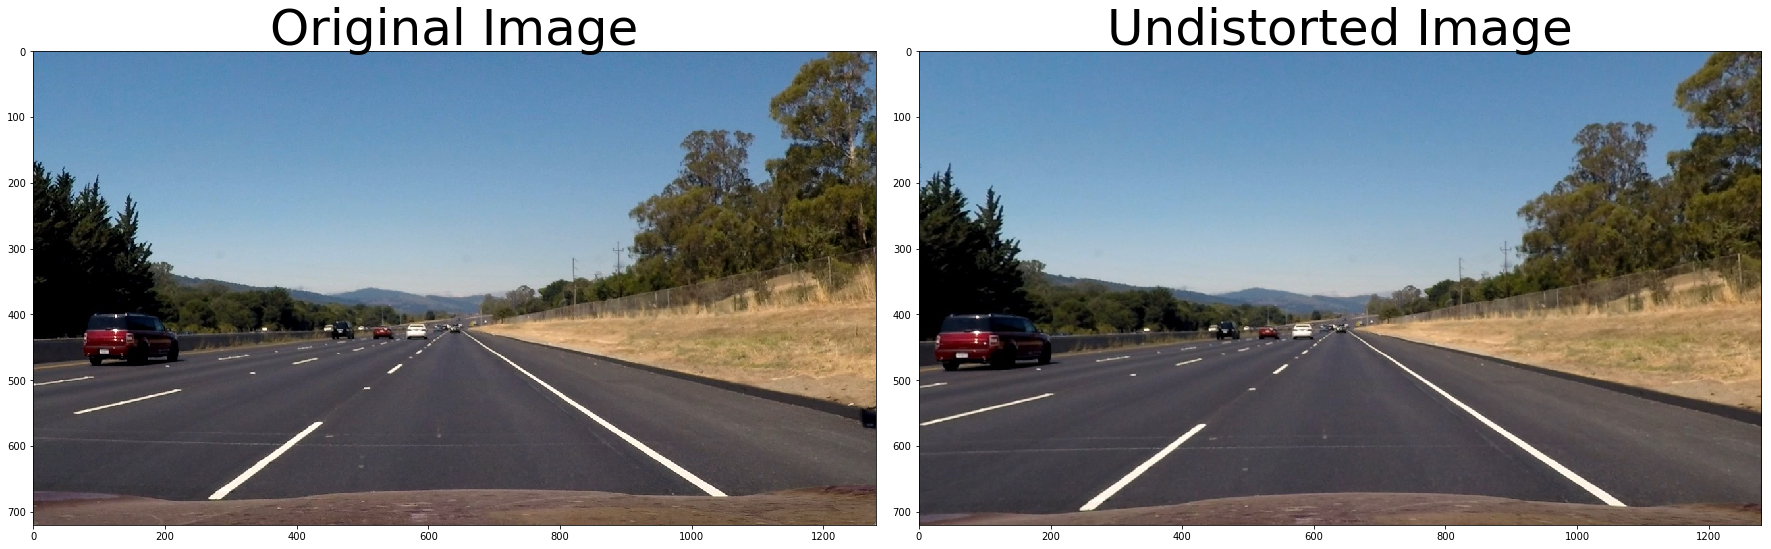

In [6]:
### Read test images, and calculate perspective transform
%matplotlib inline
# First of all, read a straight line image and run undistortion function, show it and manually measure 4 points
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

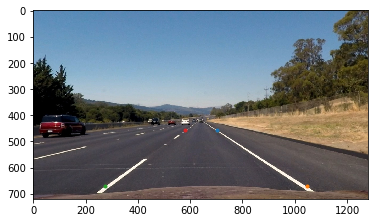

In [7]:
# Plot the 4 points together with the undistorted straight line image, run perspective transform
%matplotlib inline
plt.imshow(undistorted)
plt.plot(704,458,'.')
plt.plot(1046,670,'.')
plt.plot(276,670,'.')
plt.plot(582,458,'.')

In [8]:
# define perspective transform function here
def warp(img):
    img_size = (img.shape[1],img.shape[0])
    # 4 source points
    src = np.float32(
    [[704,458],
     [1046,670],
     [276,670],
     [582,458]])
    # 4 desired points
    dst = np.float32(
    [[1030,0],
     [1030,720],
     [250,720],
     [250,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

#Calculate M and Minv for future convenience.
src = np.float32(
    [[704,458],
     [1046,670],
     [276,670],
     [582,458]])
# 4 desired points
dst = np.float32(
    [[1030,0],
     [1030,720],
     [250,720],
     [250,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

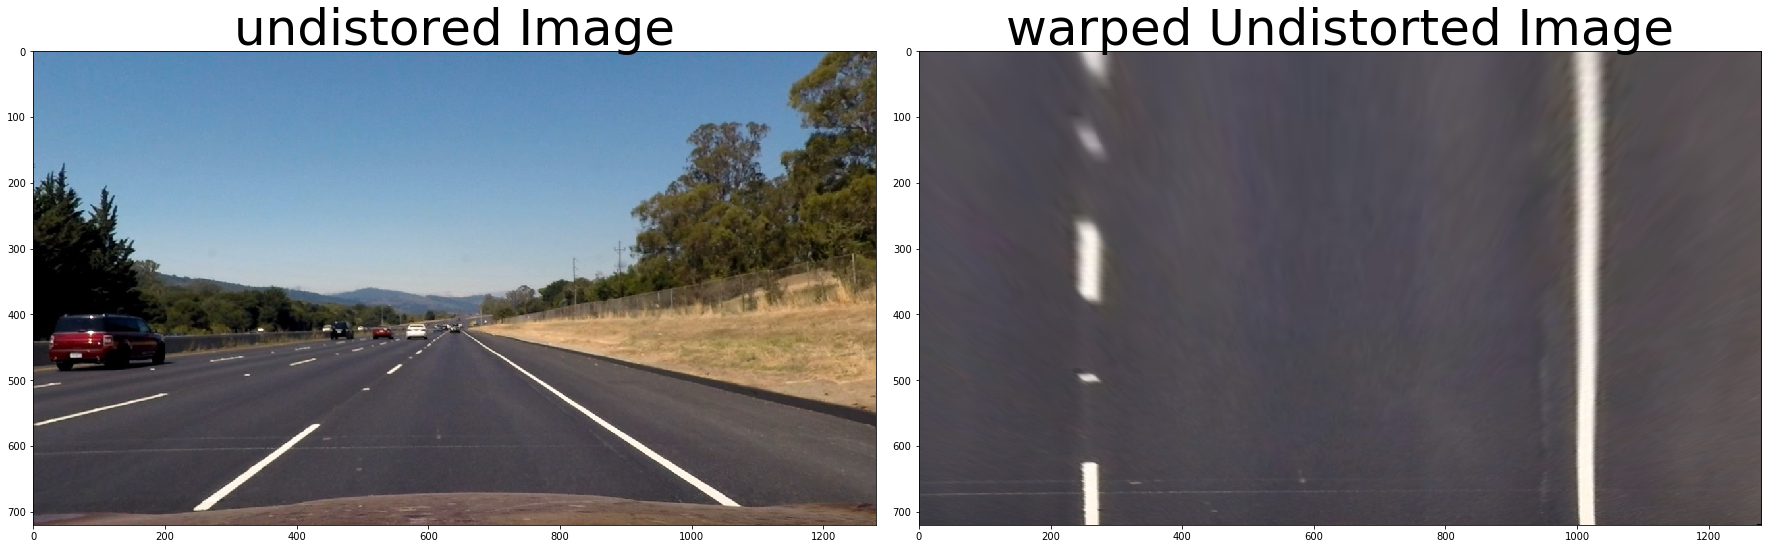

In [9]:
%matplotlib inline

img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, objpoints, imgpoints)
warped_im = warp(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('undistored Image', fontsize=50)
ax2.imshow(warped_im)
ax2.set_title('warped Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
### Define functions for gradient threshold operations

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #gray = img
    if orient=='x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    grad_binary = sxbinary # Remove this line
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx*sobelx+sobely*sobely)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    #scaled_grad_dir = np.uint8(255*grad_dir/np.max(grad_dir))
    scaled_grad_dir = grad_dir
    binary_output = np.zeros_like(scaled_grad_dir)
    binary_output[(scaled_grad_dir >= thresh[0]) & (scaled_grad_dir <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    #enalbe the following line for .png images
    #s = np.uint8(255*s/np.max(s))
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0])&(s<=thresh[1])] = 1
    return binary_output

def combo_thresh(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=(100, 255))
    s_binary = hls_select(img,thresh=(145,255))
    color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255
    combined = np.zeros_like(s_binary)
    combined[(s_binary==1)|(gradx==1)] = 1
    return color_binary,combined

In [11]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

In [12]:
# Apply each of the thresholding functions, try various combinations, choose the best one and define a function for it.
# Use undistorted RGB image as input
image = undistorted
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
s_binary = hls_select(image,thresh=(145,255))
#stack. first will be green, second will be blue
color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255

In [13]:
combined = np.zeros_like(s_binary)
combined[(s_binary==1)|(gradx==1)] = 1

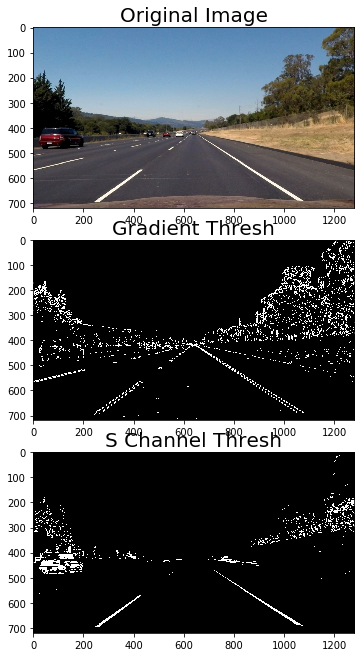

In [14]:
%matplotlib inline
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Gradient Thresh', fontsize=20)
ax3.imshow(s_binary, cmap='gray')
ax3.set_title('S Channel Thresh', fontsize=20)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

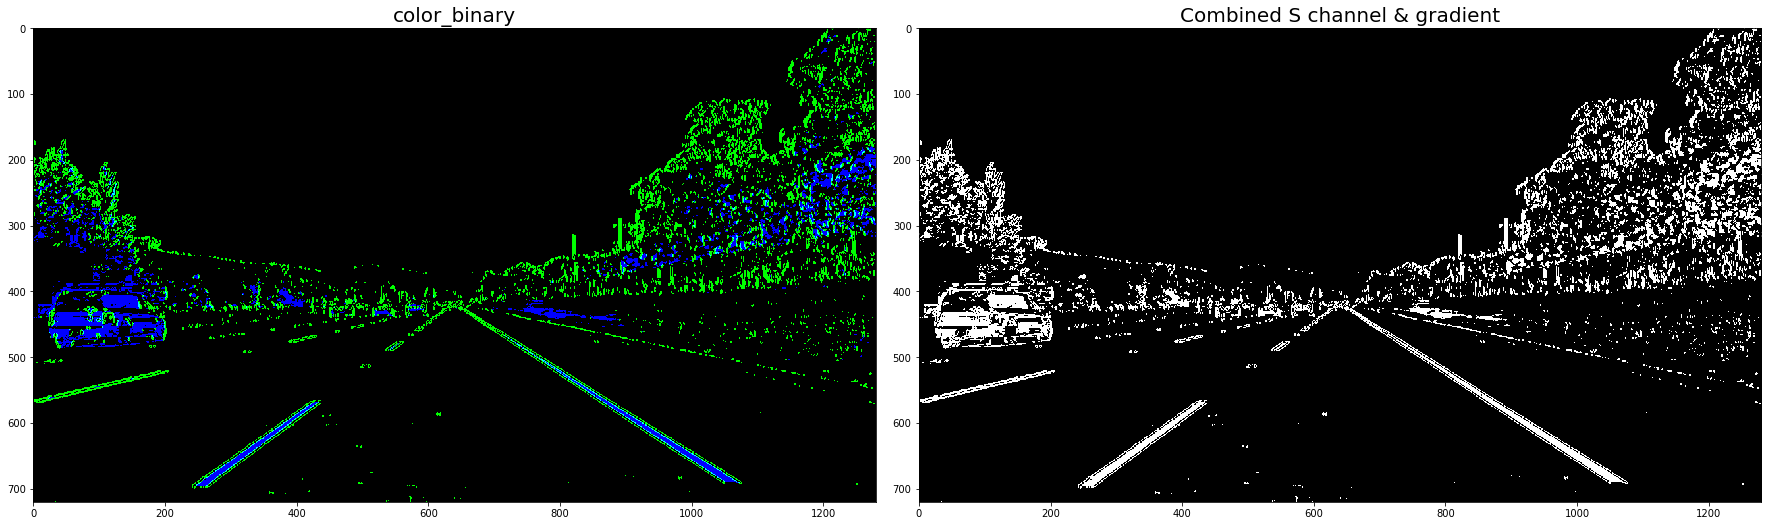

In [15]:
# Show combined effect
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('color_binary', fontsize=20)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined S channel & gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

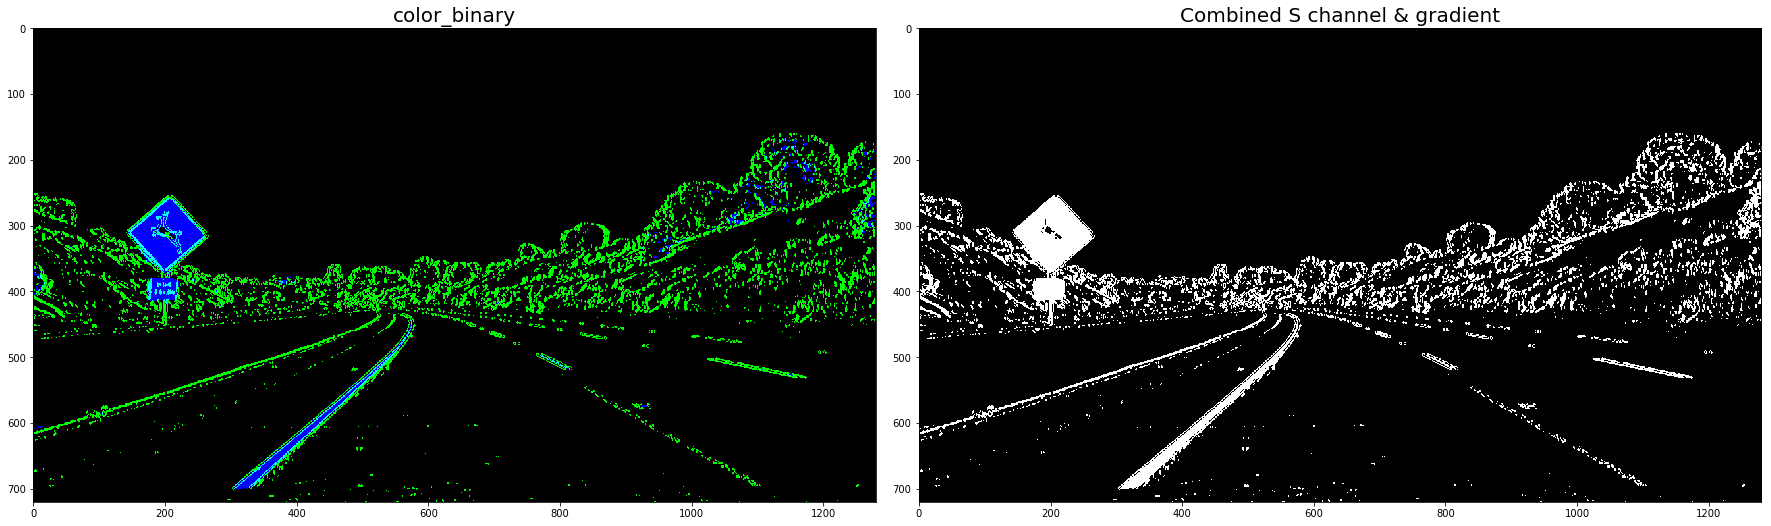

In [16]:
### Try some more difficult images
# try test1.jpg, use RGB image, first undistort it, then calculate color/gradient binary
image_in = cv2.imread('test_images/test2.jpg')
image_in = cv2.cvtColor(image_in,cv2.COLOR_BGR2RGB)
image_in_undist = cal_undistort(image_in, objpoints, imgpoints)
color_bin, combo = combo_thresh(image_in_undist)

# Show combined effect
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_bin)
ax1.set_title('color_binary', fontsize=20)
ax2.imshow(combo, cmap='gray')
ax2.set_title('Combined S channel & gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

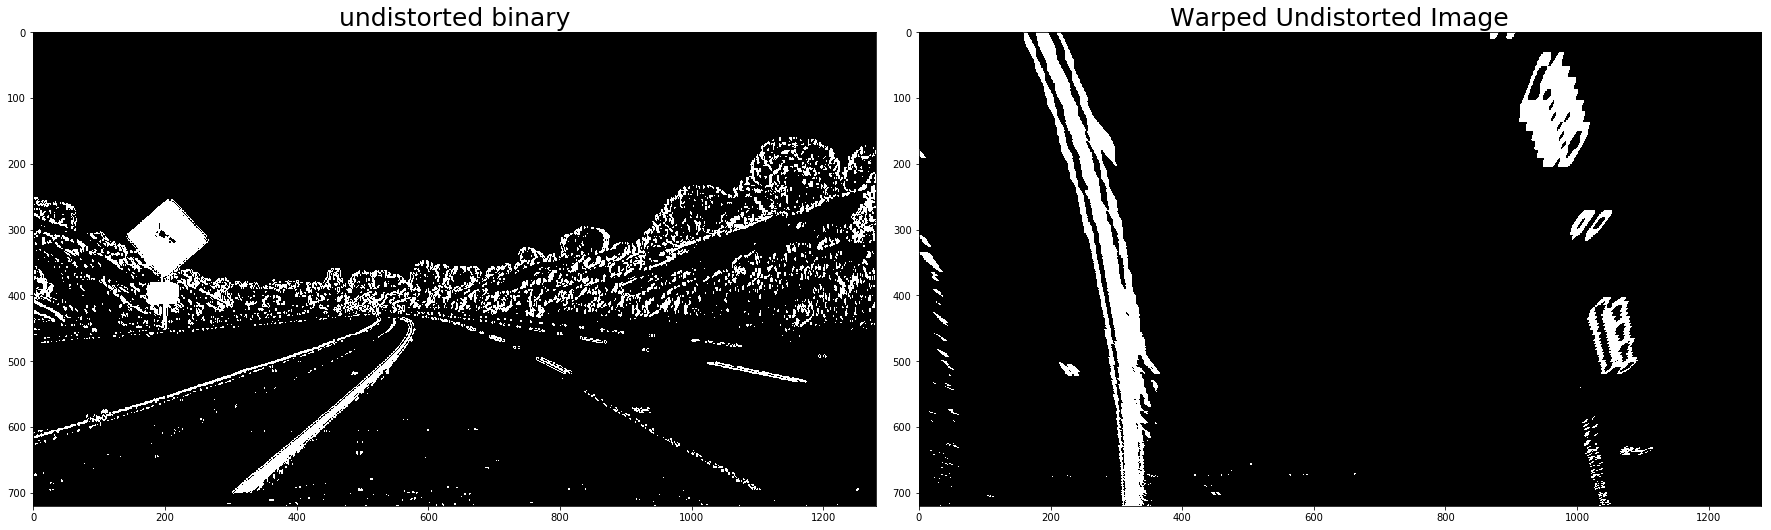

In [17]:
warped_combo = warp(combo)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combo,cmap='gray')
ax1.set_title('undistorted binary', fontsize=25)
ax2.imshow(warped_combo,cmap='gray')
ax2.set_title('Warped Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [47]:
### Find lane lines, and calculate curve radius. Wrap it in a function

def sliding_window_fit(binary_warped):
    ###
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    # Set minimum number of pixels found to recenter window
    minpix = 50

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #%matplotlib qt
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image. With this position I can calculate vehicle offset
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.66/770 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters, we need to calculate vehicle offset to lane center
    y_eval = np.max(ploty)
    left_marker_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_marker_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    offset = 640 - 0.5*(left_marker_x+right_marker_x)
    offset_m = offset*xm_per_pix
    return left_fit,right_fit,out_img,left_curverad,right_curverad,left_curverad_m,right_curverad_m,offset_m

1612.61987284 1544.41476651
587.917274605 m 562.25848147 m
-0.228977792859 m offset


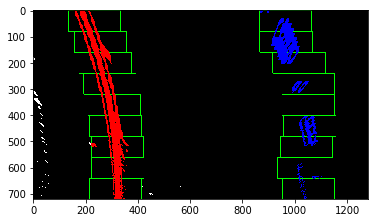

In [48]:
# Read in a warped thresholded binary image
binary_warped = warped_combo

left_fit,right_fit,out_img,left_curverad,right_curverad,left_curverad_m,right_curverad_m,offset_m = sliding_window_fit(binary_warped)
%matplotlib inline
plt.imshow(out_img)
print(left_curverad, right_curverad)
print(left_curverad_m, 'm', right_curverad_m, 'm')
print(offset_m, 'm offset')

In [27]:
def draw_lane_area(image_in_undist,warped_combo,left_fit,right_fit,Minv,ave_curv_rad_m,offset_m):
    # Create an image to draw the lines on, and then wrap it in a function
    warped = warped_combo
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Generate points for curve fitting
    ploty = np.linspace(0, warped_combo.shape[0]-1, warped_combo.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_in_undist.shape[1], image_in_undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image_in_undist, 1, newwarp, 0.3, 0)
    
    # Write Radius and Offset
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(ave_curv_rad_m) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if offset_m > 0:
        direction = 'right'
    elif offset_m < 0:
        direction = 'left'
    abs_offset_m = abs(offset_m)
    text = 'Vehicle is ' + '{:04.3f}'.format(abs_offset_m) + 'm ' + direction + ' from lane center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return result

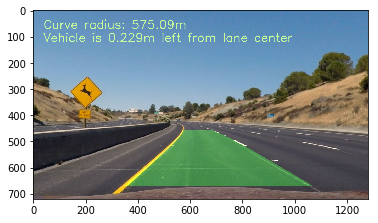

In [28]:
ave_rad_m = 0.5*(left_curverad_m + right_curverad_m)

example_out = draw_lane_area(image_in_undist, warped_combo, left_fit, right_fit, Minv,ave_rad_m,offset_m)
plt.imshow(example_out)

In [29]:
def process_img(img):
    # Convert to RGB. Disable this line when using this function to process video
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # Undistort the image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    # Apply combined threshold on the undistorted image
    color_bin, combo = combo_thresh(undistorted)
    # Warp the combined thresh binary output
    warped_combo = warp(combo)
    # Approach curve radius
    left_fit,right_fit,out_img,left_curverad,right_curverad,left_curverad_m,right_curverad_m,offset_m = sliding_window_fit(warped_combo)
    ave_rad_m = 0.5*(left_curverad_m + right_curverad_m)
    img_out = draw_lane_area(undistorted, warped_combo, left_fit, right_fit, Minv,ave_rad_m,offset_m)
    return img_out

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
white_output = 'project_video_out.mp4'

## Use the following line for a shorter subclip, use next line for entire video
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,4)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.subclip(2,4)
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [18:10<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 18min 11s
